# **Cell.1: Mount The Data**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Cell.2: Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from scipy.io import loadmat

# Metrics for evaluating model performance
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

# **Cell.3:** ***Access and Display Shape of Feature Dataset from HDF5 File***



This code accesses the 'f' dataset within an HDF5 file and prints its dimensions, essential for understanding its structure and preparing for further tasks.

In [ ]:
import h5py

features_path = '/content/drive/MyDrive/Full Datasets (PTB and MIT)/Feature Extracted by Hatem/PTB_Features2.mat'

# Open the HDF5 file and directly access the 'f' dataset
with h5py.File(features_path, 'r') as file:
    # Directly print the shape of the 'f' dataset
    print("'f' dataset shape:", file['f'].shape)


'f' dataset shape: (1, 549)


# **Cell.4:** ***Load and Access Patient Diagnosis Labels from MAT File***




This code loads a dataset of patient diagnosis labels from a MAT file, accesses specific diagnosis data from a structured array, and prints the first five labels to verify correct loading and data structure understanding.

In [ ]:
from scipy.io import loadmat

# Correctly specify the path to the labels dataset
labels_path = '/content/drive/MyDrive/Full Datasets (PTB and MIT)/Feature Extracted by Hatem/patientDiagnoses.mat'

# Load the labels dataset
label_data = loadmat(labels_path)

# Access the diagnosis data, assuming 'patientInfo' is the struct and 'diagnosis' is the field
# This correction is based on the detailed structure you've provided earlier
labels = [label[0] for label in label_data['patientInfo']['diagnosis'][0]]

print("Labels loaded. Sample label data:", labels[:5])  # Print the first 5 labels to inspect


Labels loaded. Sample label data: ['Valvular heart disease', 'Myocardial infarction', 'Myocardial infarction', 'n/a', 'Unstable angina']


# **Cell.5:** ***Extract and Flatten Features from HDF5 File***



This code opens an HDF5 file to extract and flatten data from a dataset labeled 'f'. It retrieves additional data from references and prints the total number of extracted features as well as the shape of the first set of features to ensure correct data handling and format.

In [ ]:
with h5py.File(features_path, 'r') as file:
    refs = file['#refs#']
    features_data = np.array(file['f']).flatten()  # Ensure 'f' data is appropriately flattened
    extracted_features = [np.array(refs[ref]) for ref in features_data]

    print(f"Total extracted features: {len(extracted_features)}")
    if extracted_features:
        print(f"Shape of the first feature set: {extracted_features[0].shape}")


Total extracted features: 549
Shape of the first feature set: (526, 15)


# **Cell.6:**  **Flattening the Array:**


Flattening is the process of converting a multi-dimensional array into a one-dimensional (1D) array. For example, taking a matrix (which is a 2D array) and transforming it into a single row or column of values. In this context, flattening the 15x526 matrix into a single array with 15*526 elements allows us to treat each ECG record's features as a single sample with multiple features when using machine learning models. This step is crucial because most machine learning algorithms, including KNN (K-Nearest Neighbors), expect input data in a 2D array format where each row is a sample and each column is a feature.

***Example:***

Channel 1: [1, 2, 3, 4] Channel 2: [5, 6, 7, 8] Channel 3: [9, 10, 11, 12]

This matrix visually:

[ [ 1, 2, 3, 4], [ 5, 6, 7, 8], [ 9, 10, 11, 12] ]

Flattening this matrix means transforming it into a one-dimensional array, like so:

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Now, this flat array is a single row of features for this record. If this were your ECG data, each number could represent a specific feature extracted from a channel, and by flattening it, you've prepared a single sample for your machine learning model, where every feature is a column in your dataset. In your actual case, you have 15 channels and 526 features per channel, leading to a flattened array of 15*526=7890 features per record.

In [ ]:
# Initialize an empty array with the correct shape (549, 7890)
X = np.empty((len(extracted_features), 15 * 526))

# Efficiently fill in the array with flattened data from extracted_features
for i, features in enumerate(extracted_features):
    X[i, :] = features.flatten()

print(f"Shape of the flattened feature matrix: {X.shape}")  # Confirm the shape # Should output (549, 7890)


Shape of the flattened feature matrix: (549, 7890)


# **Cell.7:** **Preparing The Labels**

**Load, Encode, and Inspect Patient Diagnosis Labels for ML Use**

This piece of code loads patient diagnosis labels from a MAT file and encodes them into a numeric format suitable for ML models using LabelEncoder.

The code extracts string labels from a structured array, transforms them into numerical categories, and prints the shape of the encoded labels to verify the transformation. Additionally, it displays unique diagnoses to understand label diversity and outputs a sample of the labels for inspection.

In [ ]:
from scipy.io import loadmat
from sklearn.preprocessing import LabelEncoder

# Specify the path to the labels dataset
labels_path = '/content/drive/MyDrive/Full Datasets (PTB and MIT)/Feature Extracted by Hatem/patientDiagnoses.mat'

# Load the label data
label_data = loadmat(labels_path)

# Extract labels using the known structure. Adjust 'diagnosis' based on the actual structure
labels = [str(label[0]) for label in label_data['patientInfo']['diagnosis'][0]]

# Encode labels into a format suitable for ML models
le = LabelEncoder()
y = le.fit_transform(labels)

# Print the shape of the encoded labels to confirm successful transformation
print(f"Encoded labels shape: {y.shape}")

# Display unique diagnoses to understand the label distribution
unique_diagnoses = set(labels)
print(f"Unique diagnoses: {unique_diagnoses}")

# Optionally, print a few sample labels for inspection
print(f"Sample labels: {labels[:5]}")


Encoded labels shape: (549,)
Unique diagnoses: {'Healthy control', 'Cardiomyopathy', 'Myocardial infarction', 'Stable angina', 'Valvular heart disease', 'Heart failure (NYHA 3)', 'Unstable angina', 'Hypertrophy', 'Myocarditis', 'Bundle branch block', 'Dysrhythmia', 'Heart failure (NYHA 4)', 'n/a', 'Palpitation', 'Heart failure (NYHA 2)'}
Sample labels: ['Valvular heart disease', 'Myocardial infarction', 'Myocardial infarction', 'n/a', 'Unstable angina']


# **Cell.8:**  **Eliminating Some Classes**

**Filter, Encode, and Analyze Specific Classes from Dataset**

This code filters and encodes patient labels for specific classes ('Myocardial infarction' and 'Healthy control') from a dataset. It identifies records with desired labels, extracts corresponding features and labels, and then encodes the labels numerically. The script confirms the process by displaying the shapes of the filtered features and encoded labels, the unique labels retained, and the distribution of the classes, ensuring that only relevant data is processed for machine learning models.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# Given labels are already loaded into 'labels'
desired_labels = ['Myocardial infarction', 'Healthy control']

# Find indexes of records with desired labels
desired_indexes = [i for i, label in enumerate(labels) if label in desired_labels]

# Filter features and labels to include only those with desired labels
X_desired = X[desired_indexes]
y_desired = [labels[i] for i in desired_indexes]

# Encoding the filtered labels
le = LabelEncoder()
y_desired_encoded = le.fit_transform(y_desired)

# Verifying the shapes after filtering and encoding
print(f"Shape of filtered features (X_desired): {X_desired.shape}")
print(f"Shape of filtered, encoded labels (y_desired_encoded): {y_desired_encoded.shape}")
print(f"Unique labels after filtering and encoding: {set(y_desired)}")

# Optional: Print class distribution
print(f"Class distribution: {Counter(y_desired_encoded)}")


Shape of filtered features (X_desired): (448, 7890)
Shape of filtered, encoded labels (y_desired_encoded): (448,)
Unique labels after filtering and encoding: {'Healthy control', 'Myocardial infarction'}
Class distribution: Counter({1: 368, 0: 80})


# **TESTING**

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Define your dataset
X = X_desired
y = y_desired_encoded

# Initialize models
models = {
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(kernel='linear', probability=True),  # You might change kernel based on your data
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=95)  # You can adjust the number of trees
}

# Setup cross-validation
kf = KFold(n_splits=9, shuffle=True, random_state=42)

# Function to evaluate each model using K-Fold cross-validation
def evaluate_models(models, X, y, kf):
    model_results = {}
    for name, model in models.items():
        cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
        model_results[name] = {
            "Accuracy": np.mean(cv_scores),
            "Standard Deviation": np.std(cv_scores)
        }
        print(f"{name} - Accuracy: {model_results[name]['Accuracy']:.4f} (+/- {model_results[name]['Standard Deviation']:.4f})")
    return model_results

# Run evaluation
results = evaluate_models(models, X, y, kf)


KNN - Accuracy: 0.8215 (+/- 0.0444)
SVC - Accuracy: 0.7969 (+/- 0.0416)
Decision Tree - Accuracy: 0.7903 (+/- 0.0428)
Random Forest - Accuracy: 0.8171 (+/- 0.0412)


# **Classifiers**

This is the X train: (398, 7890)

This is the X Test: (50, 7890)

This is the y Train: (398,)

This is the y Test: (50,)

Accuracy of Random Forest: 0.90

Accuracy of Decision Tree: 0.70

Accuracy of SVM: 0.88


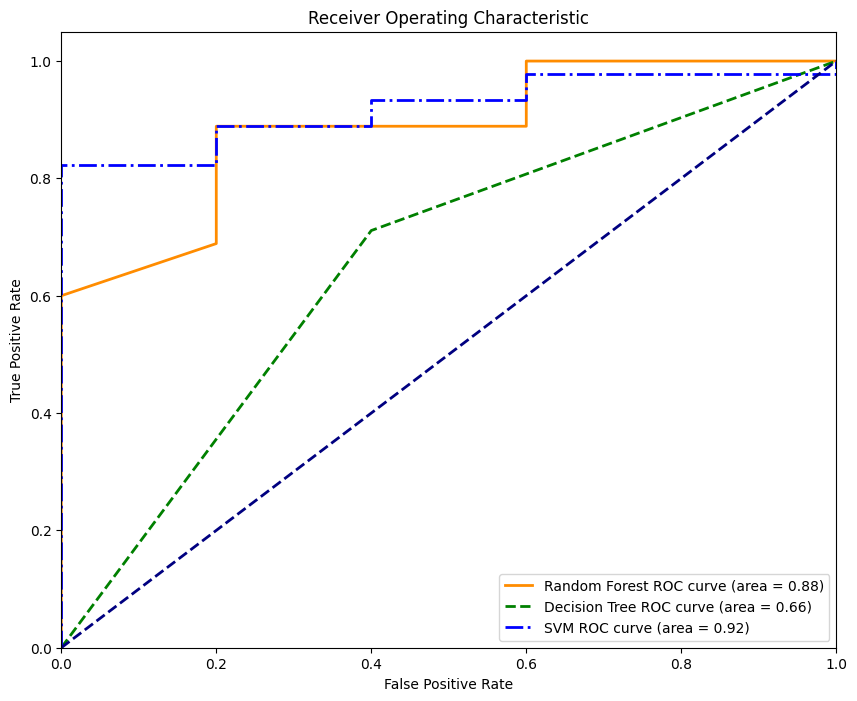

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Assuming X_desired and y_desired_encoded are your features and labels
X_train, X_test, y_train, y_test = train_test_split(X_desired, y_desired_encoded, test_size=50, random_state=42)

print(f"This is the X train: {X_train.shape}")
print(f"\nThis is the X Test: {X_test.shape}")
print(f"\nThis is the y Train: {y_train.shape}")
print(f"\nThis is the y Test: {y_test.shape}")


# Calculate the fraction of each class in y_train
class_fractions = 1 - np.bincount(y_train) / len(y_train)

# Assign weights inversely based on class fractions
weights = np.array([class_fractions[label] for label in y_train])

# Initialize the classifiers
rf = RandomForestClassifier(random_state=42)
dt = DecisionTreeClassifier(random_state=42)
svm = CalibratedClassifierCV(SVC(probability=True, random_state=42))

# Train the classifiers
rf.fit(X_train, y_train, sample_weight=weights)
dt.fit(X_train, y_train)
svm.fit(X_train, y_train)

# Plotting setup
plt.figure(figsize=(10, 8))
models = [rf, dt, svm]
model_names = ["Random Forest", "Decision Tree", "SVM"]
colors = ['darkorange', 'green', 'blue']
linestyles = ['-', '--', '-.']

for model, name, color, ls in zip(models, model_names, colors, linestyles):
    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'\nAccuracy of {name}: {accuracy:.2f}')

    # For plotting ROC curve
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, linestyle=ls, label=f'{name} ROC curve (area = {roc_auc:.2f})')

# Finish plotting
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import numpy as np

# Initialize the classifiers with tuned and adjusted parameters
knn = KNeighborsClassifier(n_neighbors=5)  # Keep adjusted n_neighbors
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=2, min_samples_split=2, random_state=42)  # Updated with optimized parameters
dt = DecisionTreeClassifier(max_depth=5, random_state=42)  # Keep added max_depth for DT
svm = SVC(kernel='rbf', C=1, probability=True, random_state=42)  # Keep changed to RBF kernel and adjusted C

# Prepare cross-validation
cv = StratifiedKFold(n_splits=10)

# Initialize dictionaries to store the metrics
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc-roc']
scores_dict = {clf: {metric: [] for metric in metrics} for clf in ['KNN', 'RF', 'DT', 'SVM']}

# Loop over each fold
for train_idx, test_idx in cv.split(X_desired, y_desired_encoded):
    X_train, X_test = X_desired[train_idx], X_desired[test_idx]
    y_train, y_test = y_desired_encoded[train_idx], y_desired_encoded[test_idx]

    for clf_name, clf in zip(['KNN', 'RF', 'DT', 'SVM'], [knn, rf, dt, svm]):
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)

        # For ROC AUC calculation
        if clf_name != 'SVM':  # For classifiers supporting predict_proba
            probabilities = clf.predict_proba(X_test)[:, 1]
        else:  # For SVM, using decision_function
            probabilities = clf.decision_function(X_test)

        # Calculate and store each metric
        scores_dict[clf_name]['accuracy'].append(accuracy_score(y_test, predictions))
        scores_dict[clf_name]['precision'].append(precision_score(y_test, predictions, zero_division=0))
        scores_dict[clf_name]['recall'].append(recall_score(y_test, predictions, zero_division=0))
        scores_dict[clf_name]['f1'].append(f1_score(y_test, predictions, zero_division=0))
        scores_dict[clf_name]['auc-roc'].append(roc_auc_score(y_test, probabilities))

# Calculate and print the mean of each metric for each classifier
for clf_name in scores_dict:
    print(f"\n{clf_name} Metrics:")
    for metric in metrics:
        mean_score = np.mean(scores_dict[clf_name][metric])
        print(f"{metric.capitalize()}: {mean_score:.3f}")



KNN Metrics:
Accuracy: 0.821
Precision: 0.821
Recall: 1.000
F1: 0.902
Auc-roc: 0.418

RF Metrics:
Accuracy: 0.821
Precision: 0.823
Recall: 0.997
F1: 0.902
Auc-roc: 0.840

DT Metrics:
Accuracy: 0.776
Precision: 0.852
Recall: 0.883
F1: 0.865
Auc-roc: 0.539

SVM Metrics:
Accuracy: 0.821
Precision: 0.821
Recall: 1.000
F1: 0.902
Auc-roc: 0.730


# **F-Folds Cross Validation**

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

# StratifiedKFold to maintain class balance
cv = StratifiedKFold(n_splits=5)

# Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Grid search with cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_desired, y_desired_encoded)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best AUC-ROC:", grid_search.best_score_)

# Apply similar optimization for SVM and GBM models


Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best AUC-ROC: 0.826552665679378


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grids for each classifier
param_grid_knn = {'n_neighbors': [5, 11, 13, 15]}
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
param_grid_dt = {'max_depth': [None, 10, 20, 30], 'min_samples_leaf': [1, 2, 4]}

# Setup GridSearchCV for each classifier
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search objects
print("Tuning KNN...")
grid_knn.fit(X_desired, y_desired_encoded)
print("Best parameters for KNN:", grid_knn.best_params_)

print("\nTuning SVM...")
grid_svm.fit(X_desired, y_desired_encoded)
print("Best parameters for SVM:", grid_svm.best_params_)

print("\nTuning Decision Tree...")
grid_dt.fit(X_desired, y_desired_encoded)
print("Best parameters for Decision Tree:", grid_dt.best_params_)


Tuning KNN...
Best parameters for KNN: {'n_neighbors': 11}

Tuning SVM...
Best parameters for SVM: {'C': 10, 'kernel': 'rbf'}

Tuning Decision Tree...
Best parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 2}


# **Applying SMOTE**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import numpy as np
from collections import Counter

# Optimized classifier initialization
knn = KNeighborsClassifier(n_neighbors=11)
rf = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10, min_samples_leaf=2, min_samples_split=2)
dt = DecisionTreeClassifier(random_state=42, max_depth=None, min_samples_leaf=2)
svm = SVC(kernel='rbf', C=10, probability=True, random_state=42)

# Prepare cross-validation
cv = StratifiedKFold(n_splits=10)

# Initialize lists to store accuracies for each classifier
scores_dict = {
    "KNN": [],
    "RF": [],
    "DT": [],
    "SVM": []
}

# Loop over each fold
for fold, (train_idx, test_idx) in enumerate(cv.split(X_desired, y_desired_encoded)):
    # Split data into training and test sets
    X_train, X_test = X_desired[train_idx], X_desired[test_idx]
    y_train, y_test = y_desired_encoded[train_idx], y_desired_encoded[test_idx]

    # Apply SMOTE to the training data (not the test data)
    smote = SMOTE()
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Train and predict with each classifier
    for clf_name, clf in zip(scores_dict.keys(), [knn, rf, dt, svm]):
        clf.fit(X_train_resampled, y_train_resampled)
        predictions = clf.predict(X_test)
        scores_dict[clf_name].append(accuracy_score(y_test, predictions))

# Calculate the mean accuracy for each classifier
for clf_name in scores_dict:
    mean_accuracy = np.mean(scores_dict[clf_name])
    print(f"{clf_name} 10-Fold CV Mean Accuracy with SMOTE: {mean_accuracy:.3f}")


KNN 10-Fold CV Mean Accuracy with SMOTE: 0.243
RF 10-Fold CV Mean Accuracy with SMOTE: 0.808
DT 10-Fold CV Mean Accuracy with SMOTE: 0.703
SVM 10-Fold CV Mean Accuracy with SMOTE: 0.821


In [ ]:
from collections import Counter

# Inside your loop, after splitting data into training and test sets, but before applying SMOTE
print(f"Original class distribution: {Counter(y_train)}")

# After applying SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"Resampled class distribution: {Counter(y_train_resampled)}")


Original class distribution: Counter({1: 332, 0: 72})
Resampled class distribution: Counter({1: 332, 0: 332})


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report

# Generate cross-validated estimates for each input data point
y_pred_knn = cross_val_predict(knn, X_desired, y_desired_encoded, cv=10)
y_pred_rf = cross_val_predict(rf, X_desired, y_desired_encoded, cv=10)

# Confusion Matrix for KNN
cm_knn = confusion_matrix(y_desired_encoded, y_pred_knn)
print("KNN Confusion Matrix:")
print(cm_knn)

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_desired_encoded, y_pred_rf)
print("Random Forest Confusion Matrix:")
print(cm_rf)

# Classification Report for KNN
print("KNN Classification Report:")
print(classification_report(y_desired_encoded, y_pred_knn))

# Classification Report for Random Forest
print("Random Forest Classification Report:")
print(classification_report(y_desired_encoded, y_pred_rf))


KNN Confusion Matrix:
[[  0  80]
 [  0 368]]
Random Forest Confusion Matrix:
[[  1  79]
 [  2 366]]
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        80
           1       0.82      1.00      0.90       368

    accuracy                           0.82       448
   macro avg       0.41      0.50      0.45       448
weighted avg       0.67      0.82      0.74       448

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.01      0.02        80
           1       0.82      0.99      0.90       368

    accuracy                           0.82       448
   macro avg       0.58      0.50      0.46       448
weighted avg       0.74      0.82      0.74       448



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Steps to enhance the results

# **Reevaluate the Feature Set**

reevaluating the feature set through dimensionality reduction and feature selection, you can introduce a new cell in your notebook. This cell would first apply Principal Component Analysis (PCA) to reduce the dimensionality of your dataset, and then explore feature importance using a tree-based model like a Random Forest for feature selection. This approach aims to identify and retain the most informative features for your model. Here's how you could structure this new cell:

Original feature set size: 7890
Reduced feature set size after PCA: 332
Number of features selected by tree-based model: 1912


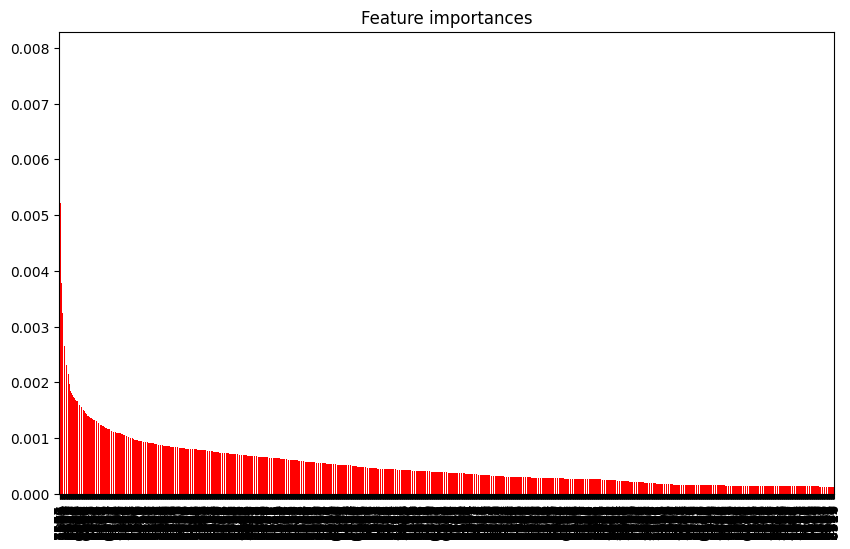

In [ ]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Apply PCA for Dimensionality Reduction
pca = PCA(n_components=0.95) # Retain 95% of the variance
X_pca = pca.fit_transform(X_desired)
print(f"Original feature set size: {X_desired.shape[1]}")
print(f"Reduced feature set size after PCA: {X_pca.shape[1]}")

# Train a Random Forest classifier to use for feature importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_desired, y_desired_encoded)

# Select features based on importance
selector = SelectFromModel(rf, prefit=True)
X_selected = selector.transform(X_desired)

# Get the support for the selected features and count them
selected_features = selector.get_support(indices=True)
print(f"Number of features selected by tree-based model: {len(selected_features)}")

# Optionally, compare performance or visualize the distribution of feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_selected.shape[1]), importances[indices[:X_selected.shape[1]]],
       color="r", align="center")
plt.xticks(range(X_selected.shape[1]), indices[:X_selected.shape[1]], rotation=90)
plt.xlim([-1, X_selected.shape[1]])
plt.show()


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from imblearn.pipeline import Pipeline
import numpy as np

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=10)

# Initialize classifiers with optimized parameters
rf_optimized = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=2, min_samples_split=2, random_state=42)
svm_optimized = SVC(kernel='rbf', C=10, probability=True, random_state=42)

# Initialize metrics
roc_auc_scores_rf_pca = []
roc_auc_scores_svm_pca = []
roc_auc_scores_rf_selected = []
roc_auc_scores_svm_selected = []

# Perform 10-fold cross-validation for PCA reduced features
for train_index, test_index in skf.split(X_pca, y_desired_encoded):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y_desired_encoded[train_index], y_desired_encoded[test_index]

    # Apply SMOTE to the training data
    smote = SMOTE()
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Train and evaluate the model
    rf_optimized.fit(X_train_resampled, y_train_resampled)
    svm_optimized.fit(X_train_resampled, y_train_resampled)

    # Predict probabilities for ROC AUC
    rf_probs = rf_optimized.predict_proba(X_test)[:, 1]
    svm_probs = svm_optimized.predict_proba(X_test)[:, 1]

    # Calculate ROC AUC and append to list
    roc_auc_scores_rf_pca.append(roc_auc_score(y_test, rf_probs))
    roc_auc_scores_svm_pca.append(roc_auc_score(y_test, svm_probs))

# Perform 10-fold cross-validation for selected features
for train_index, test_index in skf.split(X_selected, y_desired_encoded):
    X_train, X_test = X_selected[train_index], X_selected[test_index]
    y_train, y_test = y_desired_encoded[train_index], y_desired_encoded[test_index]

    # Apply SMOTE to the training data
    smote = SMOTE()
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Train and evaluate the model
    rf_optimized.fit(X_train_resampled, y_train_resampled)
    svm_optimized.fit(X_train_resampled, y_train_resampled)

    # Predict probabilities for ROC AUC
    rf_probs = rf_optimized.predict_proba(X_test)[:, 1]
    svm_probs = svm_optimized.predict_proba(X_test)[:, 1]

    # Calculate ROC AUC and append to list
    roc_auc_scores_rf_selected.append(roc_auc_score(y_test, rf_probs))
    roc_auc_scores_svm_selected.append(roc_auc_score(y_test, svm_probs))

# Calculate mean ROC AUC across folds
mean_roc_auc_rf_pca = np.mean(roc_auc_scores_rf_pca)
mean_roc_auc_svm_pca = np.mean(roc_auc_scores_svm_pca)
mean_roc_auc_rf_selected = np.mean(roc_auc_scores_rf_selected)
mean_roc_auc_svm_selected = np.mean(roc_auc_scores_svm_selected)

# Print the mean ROC AUC for each model
print(f"Mean ROC AUC for Random Forest with PCA features: {mean_roc_auc_rf_pca:.3f}")
print(f"Mean ROC AUC for SVM with PCA features: {mean_roc_auc_svm_pca:.3f}")
print(f"Mean ROC AUC for Random Forest with selected features: {mean_roc_auc_rf_selected:.3f}")
print(f"Mean ROC AUC for SVM with selected features: {mean_roc_auc_svm_selected:.3f}")


Mean ROC AUC for Random Forest with PCA features: 0.567
Mean ROC AUC for SVM with PCA features: 0.595
Mean ROC AUC for Random Forest with selected features: 0.796
Mean ROC AUC for SVM with selected features: 0.717


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=10)

# Initialize classifiers with optimized parameters
rf_optimized = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=2, min_samples_split=2, random_state=42)
svm_optimized = SVC(kernel='rbf', C=10, probability=True, random_state=42)

# Initialize resamplers
over_sampler = RandomOverSampler(sampling_strategy='minority')
under_sampler = RandomUnderSampler(sampling_strategy='majority')

# Initialize metrics
roc_auc_scores_rf_pca = []
roc_auc_scores_svm_pca = []
roc_auc_scores_rf_selected = []
roc_auc_scores_svm_selected = []

# Perform 10-fold cross-validation for PCA reduced features
for train_index, test_index in skf.split(X_pca, y_desired_encoded):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y_desired_encoded[train_index], y_desired_encoded[test_index]

    # Apply resampling to the training data
    X_train_resampled, y_train_resampled = over_sampler.fit_resample(X_train, y_train)
    X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train_resampled, y_train_resampled)

    # Train and evaluate the models
    rf_optimized.fit(X_train_resampled, y_train_resampled)
    svm_optimized.fit(X_train_resampled, y_train_resampled)

    # Predict probabilities for ROC AUC
    rf_probs = rf_optimized.predict_proba(X_test)[:, 1]
    svm_probs = svm_optimized.predict_proba(X_test)[:, 1]

    # Calculate ROC AUC and append to list
    roc_auc_scores_rf_pca.append(roc_auc_score(y_test, rf_probs))
    roc_auc_scores_svm_pca.append(roc_auc_score(y_test, svm_probs))

# Perform 10-fold cross-validation for tree-based selected features
for train_index, test_index in skf.split(X_selected, y_desired_encoded):
    X_train, X_test = X_selected[train_index], X_selected[test_index]
    y_train, y_test = y_desired_encoded[train_index], y_desired_encoded[test_index]

    # Apply resampling to the training data
    X_train_resampled, y_train_resampled = over_sampler.fit_resample(X_train, y_train)
    X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train_resampled, y_train_resampled)

    # Train and evaluate the models
    rf_optimized.fit(X_train_resampled, y_train_resampled)
    svm_optimized.fit(X_train_resampled, y_train_resampled)

    # Predict probabilities for ROC AUC
    rf_probs = rf_optimized.predict_proba(X_test)[:, 1]
    svm_probs = svm_optimized.predict_proba(X_test)[:, 1]

    # Calculate ROC AUC and append to list
    roc_auc_scores_rf_selected.append(roc_auc_score(y_test, rf_probs))
    roc_auc_scores_svm_selected.append(roc_auc_score(y_test, svm_probs))

# Calculate mean ROC AUC across folds
mean_roc_auc_rf_pca = np.mean(roc_auc_scores_rf_pca)
mean_roc_auc_svm_pca = np.mean(roc_auc_scores_svm_pca)
mean_roc_auc_rf_selected = np.mean(roc_auc_scores_rf_selected)
mean_roc_auc_svm_selected = np.mean(roc_auc_scores_svm_selected)

# Print the mean ROC AUC for each model
print(f"Mean ROC AUC for Random Forest with PCA features: {mean_roc_auc_rf_pca:.3f}")
print(f"Mean ROC AUC for SVM with PCA features: {mean_roc_auc_svm_pca:.3f}")
print(f"Mean ROC AUC for Random Forest with selected features: {mean_roc_auc_rf_selected:.3f}")
print(f"Mean ROC AUC for SVM with selected features: {mean_roc_auc_svm_selected:.3f}")


Mean ROC AUC for Random Forest with PCA features: 0.671
Mean ROC AUC for SVM with PCA features: 0.658
Mean ROC AUC for Random Forest with selected features: 0.862
Mean ROC AUC for SVM with selected features: 0.767
